## Predicting House Prices - advanced regression techniques

### Initial loading of data

Loading of the training and testing data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from helper_functions import *

%matplotlib inline
seaborn.set()

In [2]:
import helper_functions

In [316]:
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from 'C:\\Source\\predicting-house-prices\\helper_functions.py'>

In [38]:
train_df = pd.read_csv('data/train.csv')
print('Loaded %s training rows with %s columns' % (train_df.shape[0], train_df.shape[1]))

Loaded 1460 training rows with 81 columns


In [5]:
test_df = pd.read_csv('data/test.csv')
print('Loaded %s test rows with %s columns' % (test_df.shape[0], test_df.shape[1]))

Loaded 1459 test rows with 80 columns


In [6]:
# This time we train on the complete set
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

### Building a pipeline skeleton for all further steps

In [15]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

class NoFitMixin:
    def fit(self, X, y=None):
        return self

# class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy

    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        return self.func(X_)
    
class DFFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        # non-optimized default implementation; override when a better
        # method is possible
        if y is None:
            # fit method of arity 1 (unsupervised transformation)
            return self.fit(X, **fit_params).transform(X)
        else:
            # fit method of arity 2 (supervised transformation)
            return self.fit(X, y, **fit_params).transform(X)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for _, trans, weight in self._iter())
        return pd.concat(Xs, axis=1, join='inner')

### Testing the pipeline with a very simple model and only the numerical columns

In [48]:
from sklearn.model_selection import train_test_split

# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

pipeline = Pipeline([
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [10]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x000002554F608268>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [11]:
predictions = pipeline.predict(X_test)

In [12]:
# Cleaning the predictions from 0 and below
predictions[predictions <= 0] = 0

In [15]:
print_benchmark(y_test, predictions, log_transform=True)

R2-score: 0.761081041605
RMSE (log): 0.549234845034476


### Eliminate right-skewed target variable

Analyzing the distribution of the target variable SalePrice

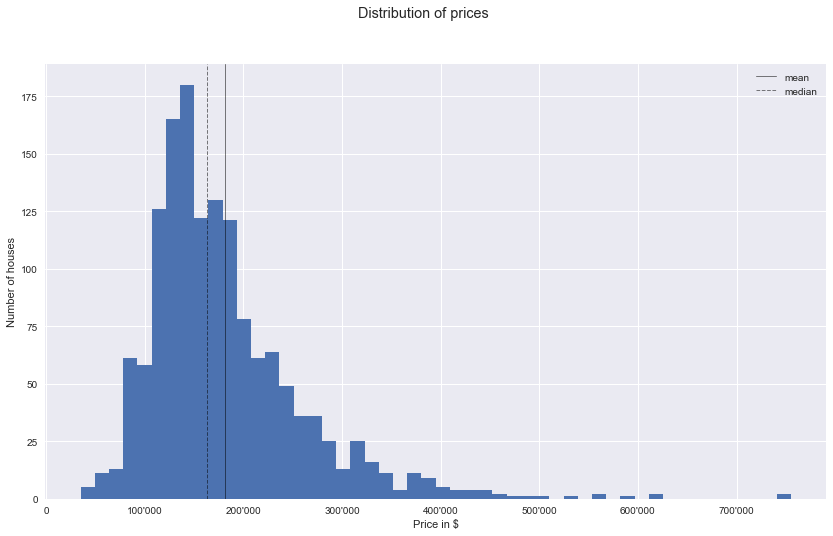

In [16]:
import matplotlib.dates as mdates
import locale
locale.setlocale(locale.LC_ALL, 'de-CH')
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))

fig, ax = plt.subplots(1, figsize=(14, 8))
fig.suptitle('Distribution of prices')
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(train_df['SalePrice'].mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(train_df['SalePrice'].median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(train_df.loc[:, 'SalePrice'], bins=50)
plt.show()

The sale price is heavily right-skewed so we will need to apply a log transform to even the distribution. This gives us a much better distribution

In [17]:
y = np.log1p(y)

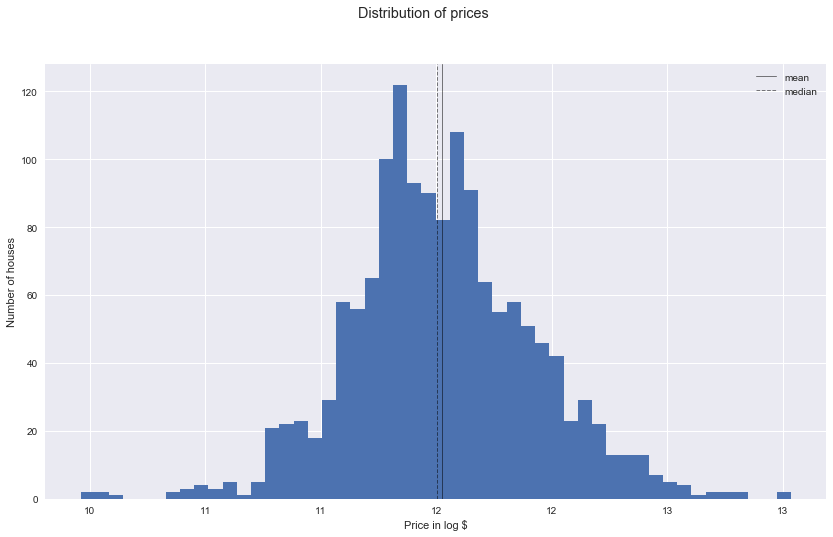

In [18]:
fig, ax = plt.subplots(1, figsize=(14, 8))
fig.suptitle('Distribution of prices')
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in log $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(y.mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(y.median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(y, bins=50)
plt.show()

We now have a much better distribution and we test the pipeline with this new distributions.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x000002554F608268>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [20]:
predictions = pipeline.predict(X_test)
predictions[predictions <= 0] = 0
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.800512687507
RMSE (log): 0.18438670596266268


We define a helper function for the process

In [298]:
def evaluate_pipeline(X_param, y_param, log_transform_param = False):
    X_train, X_test, y_train, y_test = train_test_split(X_param, y_param, test_size=.33, random_state=42)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    predictions[predictions <= 0] = 0
    print('here')
    print_benchmark(y_test, predictions, log_transform=log_transform_param)

In [46]:
evaluate_pipeline(X_numerical, y)

R2-score: 0.800512687507
RMSE (log): 0.18438670596266268


### Eliminate outliers in the data

Accoring to the documentation there are some outliers present which we remove here after we examine their presence.

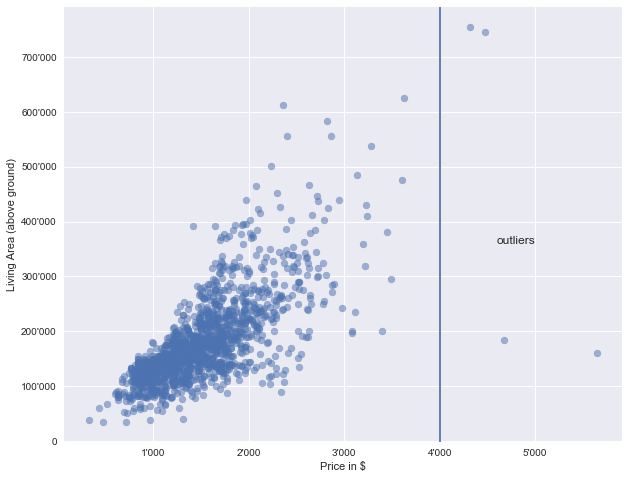

In [36]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.5)
ax.set_ylabel('Living Area (above ground)')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(4000)
ax.text(4600, 360000, 'outliers')
plt.show()

In [63]:
outliers = X[X['GrLivArea'] >= 4000]

In [64]:
print('%s outliers to remove (%s)' % (len(outliers), outliers.index))

4 outliers to remove (Int64Index([523, 691, 1182, 1298], dtype='int64'))


In [117]:
X = X.drop(outliers.index)
y = y.drop(outliers.index)

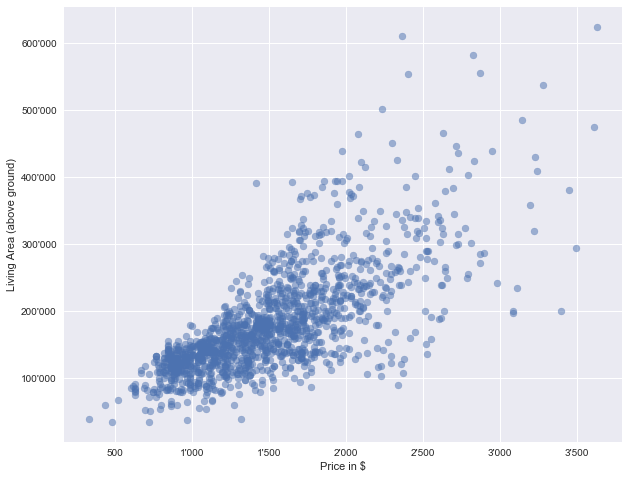

In [71]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(X['GrLivArea'], np.expm1(y), alpha=.5)
ax.set_ylabel('Living Area (above ground)')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
plt.show()

We test the pipeline with the removed outliers therefore we need to select the numerical features only again because we are not ready for the encoding of those

In [118]:
# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

In [73]:
evaluate_pipeline(X_numerical, y)

R2-score: 0.811045893083
RMSE (log): 0.17181598362314995


The score is a little bit better than with the outlies still in the dataset.

### Explore the direction of the data with principal component analysis

In [182]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_numerical)
X_numerical = scaler.transform(X_numerical)

In [183]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
pca.fit(X_numerical)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [184]:
print('Explained variance by the first 2 compoenents: %s' % pca.explained_variance_ratio_)

Explained variance by the first 2 compoenents: [ 0.18352898  0.09543763]


In [185]:
# Transform the data according to the principal components
transformed_data = pca.transform(X_numerical)

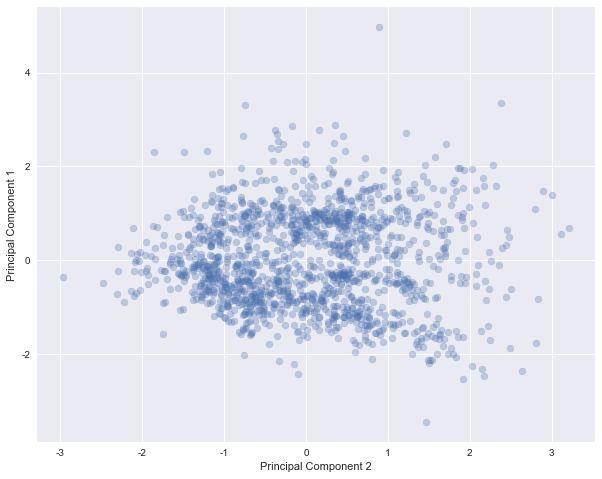

In [186]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(transformed_data[:,0], transformed_data[:,1], alpha=.3)
ax.set_ylabel('Principal Component 1')
ax.set_xlabel('Principal Component 2')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
plt.show()

But we want to analyse how many dimensions are in fact important

In [187]:
pca = PCA(whiten=True)
pca.fit(X_numerical)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [188]:
cumsum

array([ 0.18352898,  0.27896661,  0.34047822,  0.4002333 ,  0.44360774,
        0.47860357,  0.51257453,  0.54494628,  0.57681892,  0.6082521 ,
        0.63958738,  0.66920719,  0.69839373,  0.72673674,  0.75447223,
        0.78050718,  0.80556838,  0.82986338,  0.85368566,  0.87659745,
        0.89772237,  0.91577029,  0.93310012,  0.9468523 ,  0.95791541,
        0.96694865,  0.97516878,  0.98286013,  0.98869037,  0.99318327,
        0.9970844 ,  1.        ,  1.        ,  1.        ])

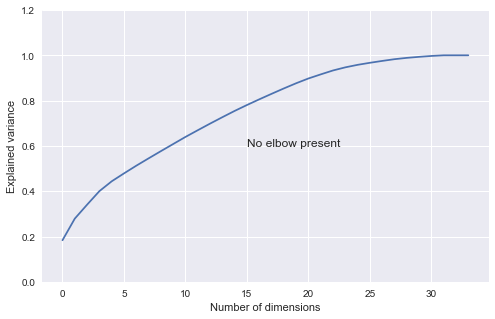

In [206]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cumsum)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Explained variance')
ax.set_ylim(0,1.2)
ax.text(15, .6, 'No elbow present')
plt.show()

pca = PCA(n_components=.95)
X_reduced = pca.fit_transform(X_numerical)

In [192]:
print('95 percent or more of the variance is eplained with %s component' % str(pca.n_components_))

95 percent or more of the variance is eplained with 25 component


With 25 components more than 95% of the variance of the data is explained.

In [196]:
X_reduced.shape

(1456, 25)

In [197]:
reduced_data = pd.DataFrame(X_reduced)

In [200]:
model = linear_model.LinearRegression()
model.fit(reduced_data, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [201]:
X_test_scaled = scaler.transform(X_test)
predictions = model.predict(pca.transform(X_test_scaled))

In [202]:
print_benchmark(np.expm1(y_test), predictions, log_transform=True)

R2-score: 0.839405887716
RMSE (log): 0.2644742897313069


** Never forget ** :
You need to scale before doing principal component analysis

### Eliminate variables which hurt the non-coolinearity assumption

Based on the previous findings we look for variables which do correlate heavily

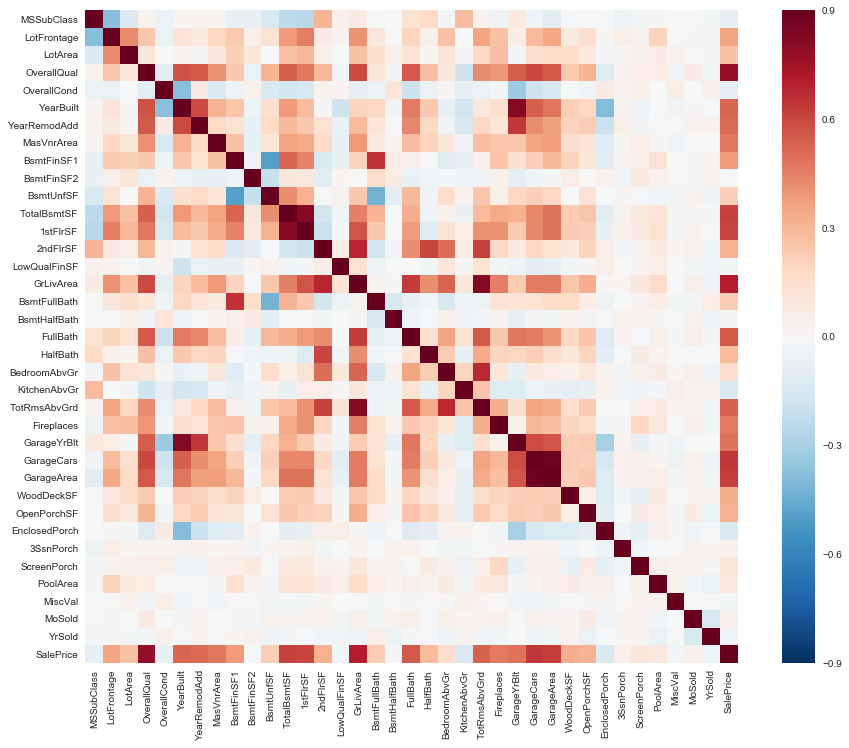

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()

corrmat = pd.read_csv('data/train.csv').drop(['Id'], axis=1).corr()
plt.subplots(figsize=(16,12))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

Features which could possibly be removed because they explain nothing

In [11]:
corrmat.loc[(corrmat['SalePrice'] < 0.05) & (corrmat['SalePrice'] > -0.05), 'SalePrice']

BsmtFinSF2     -0.011378
LowQualFinSF   -0.025606
BsmtHalfBath   -0.016844
3SsnPorch       0.044584
MiscVal        -0.021190
MoSold          0.046432
YrSold         -0.028923
Name: SalePrice, dtype: float64

Find highest correlating values and remove them because of the colinearity

In [39]:
X = train_df.drop(['Id','SalePrice'], axis=1)
y = train_df['SalePrice']

In [40]:
X = X.select_dtypes(exclude=['object'])

In [41]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X, 10))

Top Absolute Correlations
GarageCars    GarageArea      0.882475
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFinSF1    BsmtFullBath    0.649212
YearRemodAdd  GarageYrBlt     0.642277
GrLivArea     FullBath        0.630012
2ndFlrSF      TotRmsAbvGrd    0.616423
dtype: float64


In [42]:
top_correlations = get_top_abs_correlations(X, 10)
top_correlations[:5]

GarageCars   GarageArea      0.882475
YearBuilt    GarageYrBlt     0.825667
GrLivArea    TotRmsAbvGrd    0.825489
TotalBsmtSF  1stFlrSF        0.819530
2ndFlrSF     GrLivArea       0.687501
dtype: float64

In [18]:
def prepare_inputs(X_val, y_val):
    outliers = X_val[X_val['GrLivArea'] >= 4000]
    return (X_val.drop(outliers.index), np.log1p(y.drop(outliers.index)))

In [44]:
X, y = prepare_inputs(X, y)

In [57]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

pipeline = Pipeline([
    ('select_numerical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('drop_nans', DFTransform(lambda X: X.drop(X.columns[X.isnull().any(axis=0)], axis=1))),
    ('remove_high_correlations', DFTransform(lambda X: X.drop(['GarageCars',
                                                          #'GarageYrBlt',
                                                          'TotRmsAbvGrd','2ndFlrSF','TotalBsmtSF'], axis=1))),
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [58]:
evaluate_pipeline(X, y)

R2-score: 0.796404422335
RMSE (log): 0.17834854270754444


The performance (r2-score!) is a little weaker if we remove these correlation. This is interesting. What if we drop also variables with no influence to price.

In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

pipeline = Pipeline([
    ('select_numerical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('drop_nans', DFTransform(lambda X: X.drop(X.columns[X.isnull().any(axis=0)], axis=1))),
    ('remove_high_correlations', DFTransform(lambda X: X.drop(['GarageCars',
                                                          #'GarageYrBlt',
                                                          'TotRmsAbvGrd','2ndFlrSF','TotalBsmtSF'], axis=1))),
    ('remove_low_correlations', DFTransform(lambda X: X.drop(['BsmtFinSF2',
                                                          'LowQualFinSF','BsmtHalfBath','MiscVal', 'YrSold'], axis=1))),
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [60]:
evaluate_pipeline(X, y)

R2-score: 0.796404422335
RMSE (log): 0.17834854270754444


We really could remove this variables. They do not help the model.

### Handling missing input values

In [61]:
X = train_df.drop(['Id','SalePrice'], axis=1)
y = train_df['SalePrice']

In [62]:
X, y = prepare_inputs(X, y)

In [66]:
# Which columns do have null values
X.columns[X.isnull().any(axis=0)]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [69]:
# How many null rows in each column
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

LotFrontage      259
Alley           1365
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1176
MiscFeature     1402
dtype: int64

First we handle the numerical features with missing values

#### Numericals

In [148]:
X_numerical = X.select_dtypes(exclude=['object'])
null_columns = X_numerical.columns[X_numerical.isnull().any()]
X_numerical[null_columns].isnull().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

##### LotFrontage

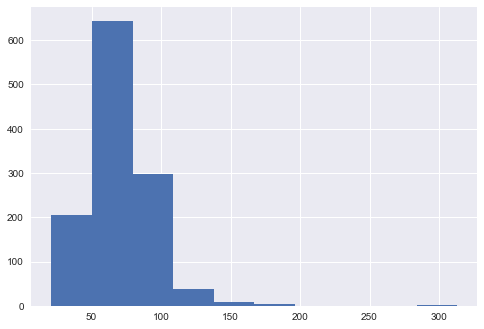

In [71]:
X_numerical['LotFrontage'].hist()

From the documentation we do not know, why there are NaNs with this features. Because there are small other values we could assume that NaNs means there are no streets connected to this properties.

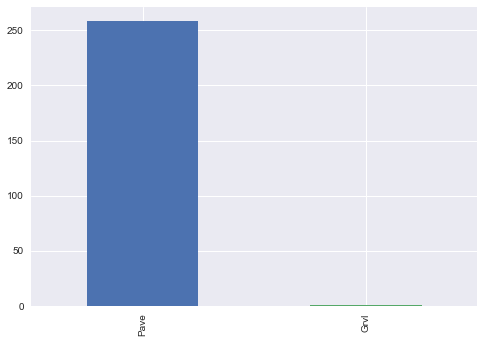

In [80]:
X[X['LotFrontage'].isnull()]['Street'].value_counts().plot(kind='bar')

But the road access does suggest, that there are actually streets. 

In [93]:
X[X['LotFrontage'].isnull()].corr().abs().iloc[0, :].sort_values(ascending=False).head()

MSSubClass     1.000000
GarageYrBlt    0.300610
YearBuilt      0.277406
2ndFlrSF       0.275932
1stFlrSF       0.244767
Name: MSSubClass, dtype: float64

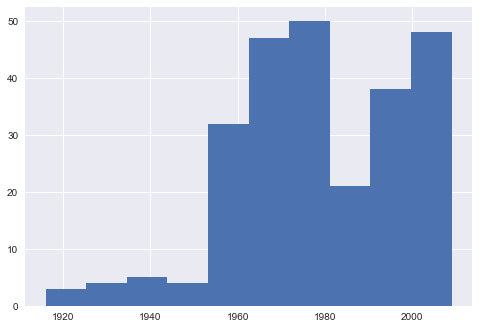

In [97]:
X[X['LotFrontage'].isnull()]['GarageYrBlt'].hist()

They even have a garage, so we fill in the medians.

##### MasVnrArea

In [132]:
X[X['MasVnrArea'].isnull()]['MasVnrType']

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

The NaNs in area are corresponding to the NaNs in type. There are not so many of those and we assume we can replace these with 0

In [263]:
def fill_numerical_nans(X_val, mean_columns, zero_columns):
    mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    mean_imputer = mean_imputer.fit(X_val.loc[:, mean_columns])
    X_new = X_val.copy()
    X_new.loc[:, mean_columns] = mean_imputer.transform(X_val.loc[:, mean_columns])
    X_new.loc[:, zero_columns] = X_new.loc[:, zero_columns].fillna(value=0)
    return X_new

#### GarageYrBlt

This feature will be possibly removed. But we handle the NaNs neverthless so that we are independent

In [144]:
X[X['GarageYrBlt'].isnull()]['GarageType'].head()

39    NaN
48    NaN
78    NaN
88    NaN
89    NaN
Name: GarageType, dtype: object

Corresponds with NaNs in type so we can safely assume there is no garage. We replace the values with 0 - so they are even older than the oldest ones.

In [147]:
X_numerical = X.select_dtypes(exclude=['object'])
X_numerical = fill_numerical_nans(X_numerical, ['LotFrontage'], ['MasVnrArea', 'GarageYrBlt'])

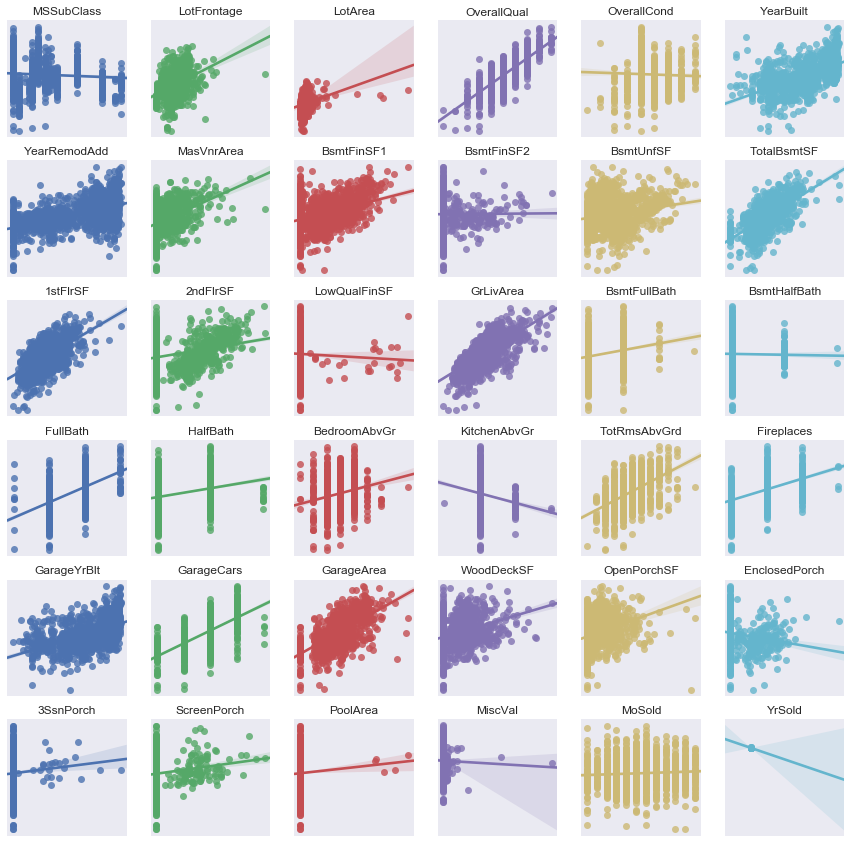

In [171]:
fig, axes = plt.subplots(6,6, figsize=(15,15))
for ax, feature in zip(axes.ravel(), X_numerical.columns):
    ax.set_title(feature)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    sns.regplot(X_numerical[feature], y, ax = ax)
plt.show()

In [551]:
'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'

('BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea')

The BsmtXXX are coresponding to no basement and can be replaced with 0 while the GarageCars are corresponding to no Garage and can also be replaced with 0

#### Categoricals

In [150]:
X_categorical = X.select_dtypes(include=['object'])
null_columns = X_categorical.columns[X_categorical.isnull().any()]
X_categorical[null_columns].isnull().sum()

Alley           1365
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1176
MiscFeature     1402
dtype: int64

In my opinion we need to use both options here, otherwise we loose one dimension if there are no nans

In [195]:
pd.get_dummies(X_categorical, dummy_na=True, drop_first=True).head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Pave,Street_nan,Alley_Pave,Alley_nan,LotShape_IR2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [560]:
def create_dummies(X_val):
    return pd.get_dummies(X_val, dummy_na=True, drop_first=True)

But there are nans in the test set which are not in our train set and these are: Index(['Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual', 'MSZoning',
       'SaleType', 'Utilities'],
      dtype='object'). So we need to add these nan columns to our structure. We need to add this to our get_dummies - see below.

So we are now ready to extend our pipeline to all the features

### Simple model with encoded variables and inputed data

In [19]:
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest

In [15]:
def fill_numerical_nans(X_val, mean_columns, zero_columns):
    print('Filling numerical nans...')
    mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    mean_imputer.fit(X_val.loc[:, mean_columns])
    X_new = X_val.copy()
    X_new.loc[:, mean_columns] = mean_imputer.transform(X_val.loc[:, mean_columns])
    X_new.loc[:, zero_columns] = X_new.loc[:, zero_columns].fillna(value=0)
    return X_new

In [16]:
def get_dummies(X_val):
    print('Creating dummies...')
    print('Starting with input of shape: %s' % str(X_val.shape))
    x_extended = pd.get_dummies(X_val, dummy_na=True, drop_first=True)
    for col in ['Exterior1st_nan', 'Exterior2nd_nan', 'Functional_nan', 'KitchenQual_nan', 
                'MSZoning_nan', 'SaleType_nan', 'Utilities_nan','Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
               'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
               'Exterior2nd_Other', 'GarageQual_Fa', 'Heating_GasA', 'Heating_OthW',
               'HouseStyle_2.5Fin', 'MiscFeature_TenC', 'PoolQC_Fa',
               'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
               'RoofMatl_Roll', 'Utilities_NoSeWa']:
        if col not in x_extended:
            x_extended.loc[:, col] = 0
    x_extended = x_extended[['MSSubClass',
                                 'LotFrontage',
                                 'LotArea',
                                 'OverallQual',
                                 'OverallCond',
                                 'YearBuilt',
                                 'YearRemodAdd',
                                 'MasVnrArea',
                                 'BsmtFinSF1',
                                 'BsmtFinSF2',
                                 'BsmtUnfSF',
                                 'TotalBsmtSF',
                                 '1stFlrSF',
                                 '2ndFlrSF',
                                 'LowQualFinSF',
                                 'GrLivArea',
                                 'BsmtFullBath',
                                 'BsmtHalfBath',
                                 'FullBath',
                                 'HalfBath',
                                 'BedroomAbvGr',
                                 'KitchenAbvGr',
                                 'TotRmsAbvGrd',
                                 'Fireplaces',
                                 'GarageYrBlt',
                                 'GarageCars',
                                 'GarageArea',
                                 'WoodDeckSF',
                                 'OpenPorchSF',
                                 'EnclosedPorch',
                                 '3SsnPorch',
                                 'ScreenPorch',
                                 'PoolArea',
                                 'MiscVal',
                                 'MoSold',
                                 'YrSold',
                                 'MSZoning_FV',
                                 'MSZoning_RH',
                                 'MSZoning_RL',
                                 'MSZoning_RM',
                                 'MSZoning_nan',
                                 'Street_Pave',
                                 'Street_nan',
                                 'Alley_Pave',
                                 'Alley_nan',
                                 'LotShape_IR2',
                                 'LotShape_IR3',
                                 'LotShape_Reg',
                                 'LotShape_nan',
                                 'LandContour_HLS',
                                 'LandContour_Low',
                                 'LandContour_Lvl',
                                 'LandContour_nan',
                                 'Utilities_NoSeWa',
                                 'Utilities_nan',
                                 'LotConfig_CulDSac',
                                 'LotConfig_FR2',
                                 'LotConfig_FR3',
                                 'LotConfig_Inside',
                                 'LotConfig_nan',
                                 'LandSlope_Mod',
                                 'LandSlope_Sev',
                                 'LandSlope_nan',
                                 'Neighborhood_Blueste',
                                 'Neighborhood_BrDale',
                                 'Neighborhood_BrkSide',
                                 'Neighborhood_ClearCr',
                                 'Neighborhood_CollgCr',
                                 'Neighborhood_Crawfor',
                                 'Neighborhood_Edwards',
                                 'Neighborhood_Gilbert',
                                 'Neighborhood_IDOTRR',
                                 'Neighborhood_MeadowV',
                                 'Neighborhood_Mitchel',
                                 'Neighborhood_NAmes',
                                 'Neighborhood_NPkVill',
                                 'Neighborhood_NWAmes',
                                 'Neighborhood_NoRidge',
                                 'Neighborhood_NridgHt',
                                 'Neighborhood_OldTown',
                                 'Neighborhood_SWISU',
                                 'Neighborhood_Sawyer',
                                 'Neighborhood_SawyerW',
                                 'Neighborhood_Somerst',
                                 'Neighborhood_StoneBr',
                                 'Neighborhood_Timber',
                                 'Neighborhood_Veenker',
                                 'Neighborhood_nan',
                                 'Condition1_Feedr',
                                 'Condition1_Norm',
                                 'Condition1_PosA',
                                 'Condition1_PosN',
                                 'Condition1_RRAe',
                                 'Condition1_RRAn',
                                 'Condition1_RRNe',
                                 'Condition1_RRNn',
                                 'Condition1_nan',
                                 'Condition2_Feedr',
                                 'Condition2_Norm',
                                 'Condition2_PosA',
                                 'Condition2_PosN',
                                 'Condition2_RRAe',
                                 'Condition2_RRAn',
                                 'Condition2_RRNn',
                                 'Condition2_nan',
                                 'BldgType_2fmCon',
                                 'BldgType_Duplex',
                                 'BldgType_Twnhs',
                                 'BldgType_TwnhsE',
                                 'BldgType_nan',
                                 'HouseStyle_1.5Unf',
                                 'HouseStyle_1Story',
                                 'HouseStyle_2.5Fin',
                                 'HouseStyle_2.5Unf',
                                 'HouseStyle_2Story',
                                 'HouseStyle_SFoyer',
                                 'HouseStyle_SLvl',
                                 'HouseStyle_nan',
                                 'RoofStyle_Gable',
                                 'RoofStyle_Gambrel',
                                 'RoofStyle_Hip',
                                 'RoofStyle_Mansard',
                                 'RoofStyle_Shed',
                                 'RoofStyle_nan',
                                 'RoofMatl_Membran',
                                 'RoofMatl_Metal',
                                 'RoofMatl_Roll',
                                 'RoofMatl_Tar&Grv',
                                 'RoofMatl_WdShake',
                                 'RoofMatl_WdShngl',
                                 'RoofMatl_nan',
                                 'Exterior1st_AsphShn',
                                 'Exterior1st_BrkComm',
                                 'Exterior1st_BrkFace',
                                 'Exterior1st_CBlock',
                                 'Exterior1st_CemntBd',
                                 'Exterior1st_HdBoard',
                                 'Exterior1st_ImStucc',
                                 'Exterior1st_MetalSd',
                                 'Exterior1st_Plywood',
                                 'Exterior1st_Stone',
                                 'Exterior1st_Stucco',
                                 'Exterior1st_VinylSd',
                                 'Exterior1st_Wd Sdng',
                                 'Exterior1st_WdShing',
                                 'Exterior1st_nan',
                                 'Exterior2nd_AsphShn',
                                 'Exterior2nd_Brk Cmn',
                                 'Exterior2nd_BrkFace',
                                 'Exterior2nd_CBlock',
                                 'Exterior2nd_CmentBd',
                                 'Exterior2nd_HdBoard',
                                 'Exterior2nd_ImStucc',
                                 'Exterior2nd_MetalSd',
                                 'Exterior2nd_Other',
                                 'Exterior2nd_Plywood',
                                 'Exterior2nd_Stone',
                                 'Exterior2nd_Stucco',
                                 'Exterior2nd_VinylSd',
                                 'Exterior2nd_Wd Sdng',
                                 'Exterior2nd_Wd Shng',
                                 'Exterior2nd_nan',
                                 'MasVnrType_BrkFace',
                                 'MasVnrType_None',
                                 'MasVnrType_Stone',
                                 'MasVnrType_nan',
                                 'ExterQual_Fa',
                                 'ExterQual_Gd',
                                 'ExterQual_TA',
                                 'ExterQual_nan',
                                 'ExterCond_Fa',
                                 'ExterCond_Gd',
                                 'ExterCond_Po',
                                 'ExterCond_TA',
                                 'ExterCond_nan',
                                 'Foundation_CBlock',
                                 'Foundation_PConc',
                                 'Foundation_Slab',
                                 'Foundation_Stone',
                                 'Foundation_Wood',
                                 'Foundation_nan',
                                 'BsmtQual_Fa',
                                 'BsmtQual_Gd',
                                 'BsmtQual_TA',
                                 'BsmtQual_nan',
                                 'BsmtCond_Gd',
                                 'BsmtCond_Po',
                                 'BsmtCond_TA',
                                 'BsmtCond_nan',
                                 'BsmtExposure_Gd',
                                 'BsmtExposure_Mn',
                                 'BsmtExposure_No',
                                 'BsmtExposure_nan',
                                 'BsmtFinType1_BLQ',
                                 'BsmtFinType1_GLQ',
                                 'BsmtFinType1_LwQ',
                                 'BsmtFinType1_Rec',
                                 'BsmtFinType1_Unf',
                                 'BsmtFinType1_nan',
                                 'BsmtFinType2_BLQ',
                                 'BsmtFinType2_GLQ',
                                 'BsmtFinType2_LwQ',
                                 'BsmtFinType2_Rec',
                                 'BsmtFinType2_Unf',
                                 'BsmtFinType2_nan',
                                 'Heating_GasA',
                                 'Heating_GasW',
                                 'Heating_Grav',
                                 'Heating_OthW',
                                 'Heating_Wall',
                                 'Heating_nan',
                                 'HeatingQC_Fa',
                                 'HeatingQC_Gd',
                                 'HeatingQC_Po',
                                 'HeatingQC_TA',
                                 'HeatingQC_nan',
                                 'CentralAir_Y',
                                 'CentralAir_nan',
                                 'Electrical_FuseF',
                                 'Electrical_FuseP',
                                 'Electrical_Mix',
                                 'Electrical_SBrkr',
                                 'Electrical_nan',
                                 'KitchenQual_Fa',
                                 'KitchenQual_Gd',
                                 'KitchenQual_TA',
                                 'KitchenQual_nan',
                                 'Functional_Maj2',
                                 'Functional_Min1',
                                 'Functional_Min2',
                                 'Functional_Mod',
                                 'Functional_Sev',
                                 'Functional_Typ',
                                 'Functional_nan',
                                 'FireplaceQu_Fa',
                                 'FireplaceQu_Gd',
                                 'FireplaceQu_Po',
                                 'FireplaceQu_TA',
                                 'FireplaceQu_nan',
                                 'GarageType_Attchd',
                                 'GarageType_Basment',
                                 'GarageType_BuiltIn',
                                 'GarageType_CarPort',
                                 'GarageType_Detchd',
                                 'GarageType_nan',
                                 'GarageFinish_RFn',
                                 'GarageFinish_Unf',
                                 'GarageFinish_nan',
                                 'GarageQual_Fa',
                                 'GarageQual_Gd',
                                 'GarageQual_Po',
                                 'GarageQual_TA',
                                 'GarageQual_nan',
                                 'GarageCond_Fa',
                                 'GarageCond_Gd',
                                 'GarageCond_Po',
                                 'GarageCond_TA',
                                 'GarageCond_nan',
                                 'PavedDrive_P',
                                 'PavedDrive_Y',
                                 'PavedDrive_nan',
                                 'PoolQC_Fa',
                                 'PoolQC_Gd',
                                 'PoolQC_nan',
                                 'Fence_GdWo',
                                 'Fence_MnPrv',
                                 'Fence_MnWw',
                                 'Fence_nan',
                                 'MiscFeature_Othr',
                                 'MiscFeature_Shed',
                                 'MiscFeature_TenC',
                                 'MiscFeature_nan',
                                 'SaleType_CWD',
                                 'SaleType_Con',
                                 'SaleType_ConLD',
                                 'SaleType_ConLI',
                                 'SaleType_ConLw',
                                 'SaleType_New',
                                 'SaleType_Oth',
                                 'SaleType_WD',
                                 'SaleType_nan',
                                 'SaleCondition_AdjLand',
                                 'SaleCondition_Alloca',
                                 'SaleCondition_Family',
                                 'SaleCondition_Normal',
                                 'SaleCondition_Partial',
                                 'SaleCondition_nan',
                                 'RoofMatl_CompShg']]
    print('Returning output of shape: %s' % str(x_extended.shape))
    return x_extended

In [58]:
train_df = pd.read_csv('data/train.csv')

In [59]:
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']

In [60]:
def prepare_inputs(X_val, y_val):
    outliers = X_val[X_val['GrLivArea'] >= 4000]
    return (X_val.drop(outliers.index), np.log1p(y.drop(outliers.index)))

In [61]:
X, y = prepare_inputs(X, y)

In [81]:
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X_a: fill_numerical_nans(X_a, ['LotFrontage'], ['MasVnrArea', 
                                                                                            'GarageYrBlt',
                                                                                            'BsmtFinSF1',
                                                                                            'BsmtFinSF2',
                                                                                            'BsmtUnfSF',
                                                                                            'TotalBsmtSF',
                                                                                            'BsmtFullBath',
                                                                                            'BsmtHalfBath',
                                                                                            'GarageCars',
                                                                                            'GarageArea']))),
    ('encode_dummies', DFTransform(lambda X_a: get_dummies(X_a)))
])

In [63]:
X = trans_pipeline.fit_transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


In [82]:
pipeline = Pipeline([
    ('lin_reg', LinearRegression())
])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [66]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [67]:
predictions = pipeline.predict(X_test)

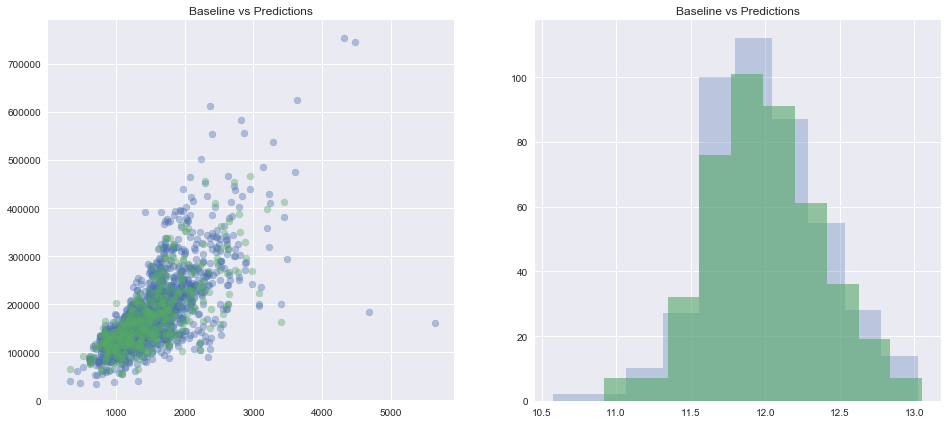

R2-score: 0.867192915026
RMSE (log): 0.1403652639948691


In [68]:
plot_benchmark(X_test, y_test, predictions)

Make the predictions for the test set. But first we want to train on the whole set without train and test split

In [69]:
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']
X, y = prepare_inputs(X, y)
X = trans_pipeline.fit_transform(X)
pipeline.fit(X, y)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [70]:
test_df = pd.read_csv('data/test.csv')
X = test_df.drop(['Id'], axis=1)
X = trans_pipeline.transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1459, 79)
Returning output of shape: (1459, 288)


In [71]:
predictions = pipeline.predict(X)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 157335.28
Difference in means is: -23585.9177049
IMPORTANT: There is something wrong with your predictions!!!


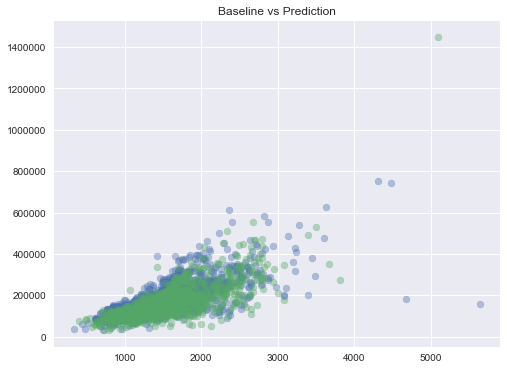

In [73]:
draw_sanity_check(predictions, False)

In [27]:
write_submission(test_df, np.expm1(predictions))

File written to C:\Source\predicting-house-prices\submissions\20180721204847.csv


Kaggle score: 0.21469

### Building a better pipeline with cross validation

In [98]:
def rsme_log(y_actual, y_predicted):
    return math.sqrt(mean_squared_error(y_actual, y_predicted))

In [22]:
from sklearn.metrics import make_scorer

In [92]:
train_df = pd.read_csv('data/train.csv')
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']
X, y = prepare_inputs(X, y)

In [93]:
X = trans_pipeline.fit_transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


In [100]:
from sklearn.cross_validation import cross_val_score
scorer = make_scorer(rsme_log)
cross_val_score(pipeline, X, y, cv=5, scoring=scorer)

array([ 0.12468363,  0.13696554,  0.14420381,  0.10996149,  0.12675848])

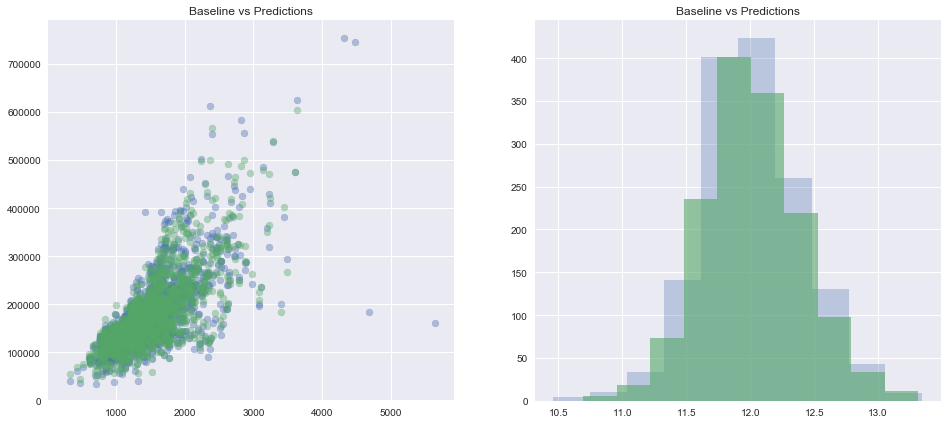

R2-score: 0.947845293788
RMSE (log): 0.0904226972302732


In [101]:
pipeline.fit(X, y)
predictions = pipeline.predict(X)
plot_benchmark(X, y, predictions)

This naturally is overfitted because we have done no split. But cross validation does not help us very much.

### Optimizing our dummy variable converter and using LabelEncoder

Some special cases of our categorical features need to be handles first

In [1]:
# moved to helper functions

Ordinal features need to be converted with label encoder

In [16]:
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
])

### Changing to transform all data at once - only way this can work

In [465]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)

In [466]:
X_train, y_train = prepare_inputs(X_train, y_train)
X_train.shape

(1456, 79)

In [467]:
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 

In [468]:
X_tranformed = trans_pipeline.fit_transform(X_combined)

Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)


In [469]:
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

In [470]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_trans, y_train, test_size=.33, random_state=42)

In [471]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [472]:
predictions = pipeline.predict(X_test)

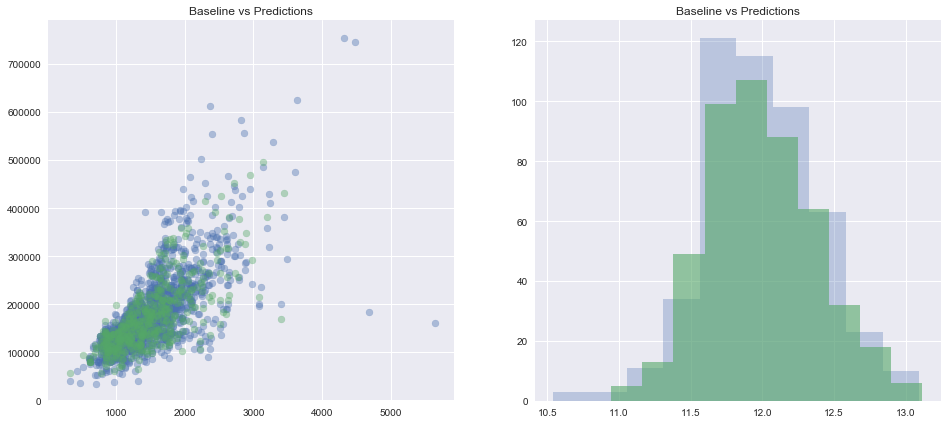

R2-score: 0.883987658729
RMSE (log): 0.1346286499098431


In [473]:
plot_benchmark(X_test, y_test, predictions)

### Automating pipeline, training, prediction and submission

In [3]:
def prepare_inputs(X_val, y_val):
    outliers = X_val[X_val['GrLivArea'] >= 4000]
    return (X_val.drop(outliers.index), np.log1p(y_val.drop(outliers.index)))

In [10]:
(trans_p, fit_p, _) = train_pipeline(Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ]), 
    Pipeline([
    ('lin_reg', LinearRegression())
]))

NameError: name 'LinearRegression' is not defined

And now also make a method for the execution of the pipeline:

In [8]:
def execute_pipeline(transformation_pipeline, fitted_pipeline, transformed_x):
    predictions = fitted_pipeline.predict(transformed_x)
    draw_sanity_check(predictions, False)
    return predictions

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179437.58
Difference in means is: -1483.61339445


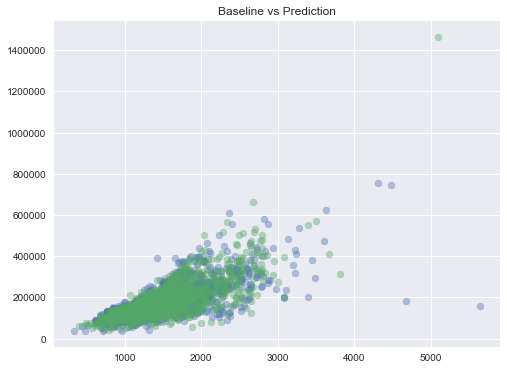

In [491]:
predictions = execute_pipeline(trans_p, fit_p, X_test_trans)

In [492]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180722135957.csv


Kaggle score: 0.13133

The kaggle score does match very well to our local score though there are some signs of possible overfitting (0.95 to 0.88 R2-Score). We want to explore this closer.

### Explore possible overfitting

In [6]:
seaborn.set()

def plot_learning_curve(transformation_pipeline, estimation_pipeline):
    train_df =  pd.read_csv('data/train.csv')
    X_train = train_df.drop(['SalePrice','Id'], axis=1)
    y_train = train_df['SalePrice']
    X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
    X_train, y_train = prepare_inputs(X_train, y_train)
    X_train_trans = transformation_pipeline.fit_transform(X_train)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_trans, y_train, test_size=.33, random_state=42)
    
    
    train_errors, val_errors = [],[]
    for m in range(1, len(X_train)):
        estimation_pipeline.fit(X_train[:m], y_train[:m])
        y_train_predict = estimation_pipeline.predict(X_train[:m])
        y_valid_predict = estimation_pipeline.predict(X_valid)
        
        train_errors.append(math.sqrt(mean_squared_error(y_train_predict, y_train[:m])))
        val_errors.append(math.sqrt(mean_squared_error(y_valid_predict, y_valid)))
    
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.plot(train_errors)
    ax.plot(val_errors)
    ax.set_xlabel('training size')
    ax.set_ylabel('RMSE (log)')
    ax.set_ylim([0, 1])
    plt.title('Training curve')
    plt.legend(['training', 'validation'])
    plt.show()
    print_benchmark(y_valid, y_valid_predict)

In [17]:
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ])

In [ ]:
plot_learning_curve(trans_pipeline, 
    Pipeline([
    ('lin_reg', LinearRegression())
]))

The plot is not clear at the moment. The curves are pretty close but not to close and the error is got but can be improved. The validation curve seems to have potential but we did not see any polynomial correlations in our model. We try another model to compare.

### Ridge Regression - Closed Form Method - l2 method

Ridge regression allows us to do regularization. We explore regularization with a grid search.

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


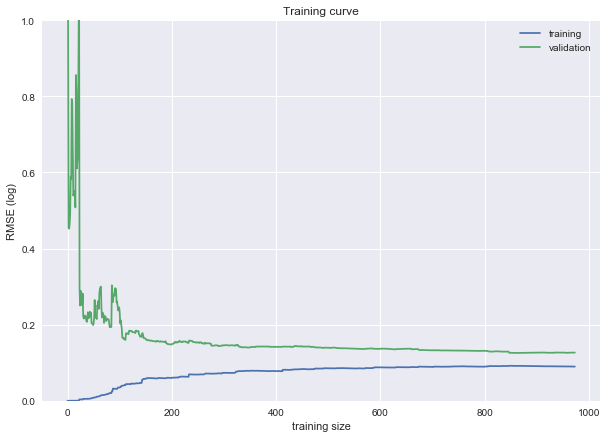

R2-score: 0.897419732704
RMSE (log): 0.12659522006263185


In [547]:
from sklearn.linear_model import Ridge

plot_learning_curve(trans_pipeline, 
    Pipeline([
        ('ridge_regression', Ridge(alpha=1, solver='cholesky'))
]))

Result is a little bit better. We try to use grid search here.

In [4]:
from sklearn.model_selection import GridSearchCV       

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
     
def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('ridge_regression', Ridge(solver='cholesky'))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

NameError: name 'prepare_inputs' is not defined

In [566]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('ridge_regression', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001))])

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


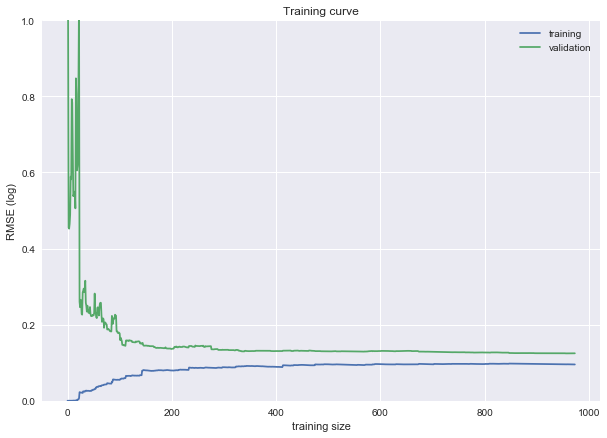

R2-score: 0.900470661643
RMSE (log): 0.1246984207500989


In [567]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.941804551552
RMSE (log): 0.09533071939950581
Create predictions...(test)


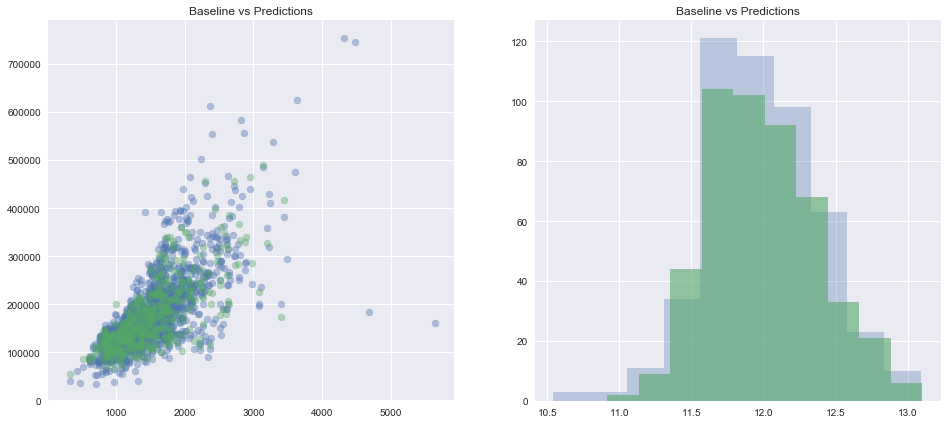

R2-score: 0.900409068211
RMSE (log): 0.12473699940409354
Fitting the pipeline to all the data...
Score: 0.93452305


In [570]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179206.01
Difference in means is: -1715.18196257


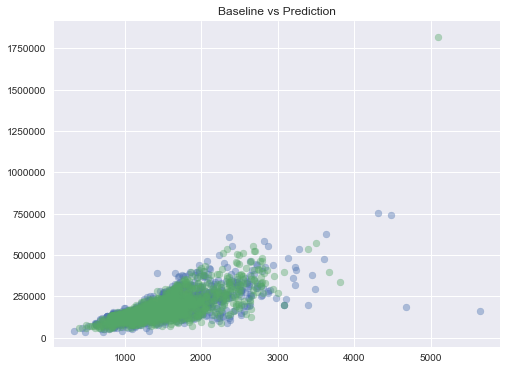

In [571]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [572]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180722165430.csv


Kaggle score: 0.12114

The reqularization has had some impact and the score improved. We can now try other models.

### Stochastic Gradient Descent - Non closed

In [575]:
from sklearn.model_selection import GridSearchCV    
from sklearn.linear_model import SGDRegressor

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'sgd_regression__penalty': ['l1', 'l2', 'elasticnet']}
     
def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('sgd_regression', SGDRegressor(penalty='l2'))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train.ravel())

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('sgd_regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sgd_regression__penalty': ['l1', 'l2', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


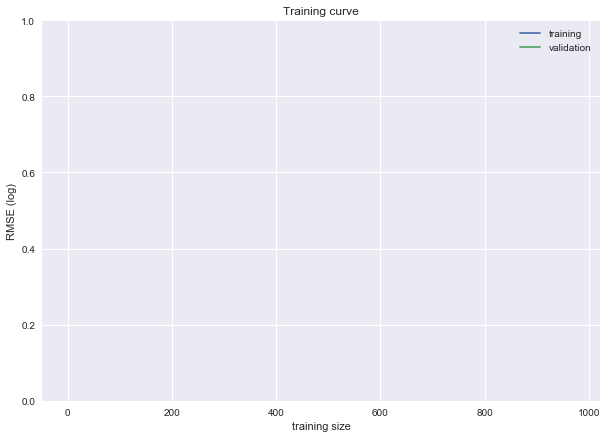

R2-score: -2.33298079594e+34
RMSE (log): 6.037275253511089e+16


In [576]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

No meaningful result. We skip this algorithm. Maybe there are to few samples - see sklearn diagram

### Lasso regression - l1 method

Uses l1 regularization instead of l2. Lets wee what this will bring. We also use grid search.

In [584]:
from sklearn.model_selection import GridSearchCV       

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'lasso_regression__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'lasso_regression__normalize' : [True, False]}

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('lasso_regression', Lasso(alpha=1))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('lasso_regression', Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_regression__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'lasso_regression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Lets see what the best parameter is.

In [586]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('lasso_regression', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [ ]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Result with l1 (lasso) is even a little bit better than with ridge. But the result is small.

Because lasso is sensitive to outliers, we also try the algorithm with a scaling before. For this we use add the RobustScaler to our pipeline.

In [591]:
import warnings
warnings.simplefilter("once")

from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import RobustScaler

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'lasso_regression__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'lasso_regression__normalize' : [True, False],
              'robust_scaler__with_scaling' : [True, False],
              'robust_scaler__with_centering' : [True, False]
             }

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('robust_scaler', RobustScaler()),
        ('lasso_regression', Lasso(alpha=1))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('robust_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso_regression', Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_regression__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'lasso_regression__normalize': [True, False], 'robust_scaler__with_scaling': [True, False], 'robust_scaler__with_centering': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [592]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('robust_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
       with_scaling=False)), ('lasso_regression', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

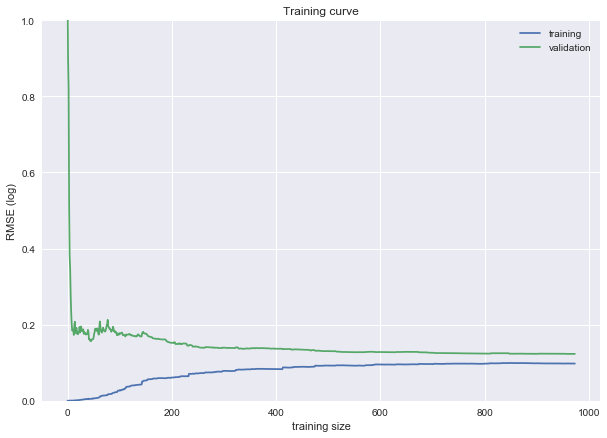

R2-score: 0.902889222068
RMSE (log): 0.12317401881733071


In [593]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

The robust scaler did not bring anything good. Maybe the normalize did the same thing as well. So we remove the robust scaler again and make a submission. We also try to increase the number of iterations.

In [597]:
from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import RobustScaler

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'lasso_regression__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'lasso_regression__normalize' : [True, False]
             }

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('lasso_regression', Lasso(alpha=1, max_iter=3000))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('lasso_regression', Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=3000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_regression__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'lasso_regression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


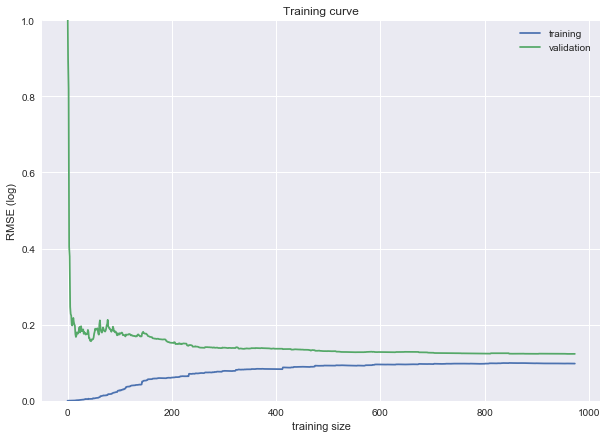

R2-score: 0.902889222068
RMSE (log): 0.12317401881733071


In [598]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.93891519239
RMSE (log): 0.09766860078185423
Create predictions...(test)


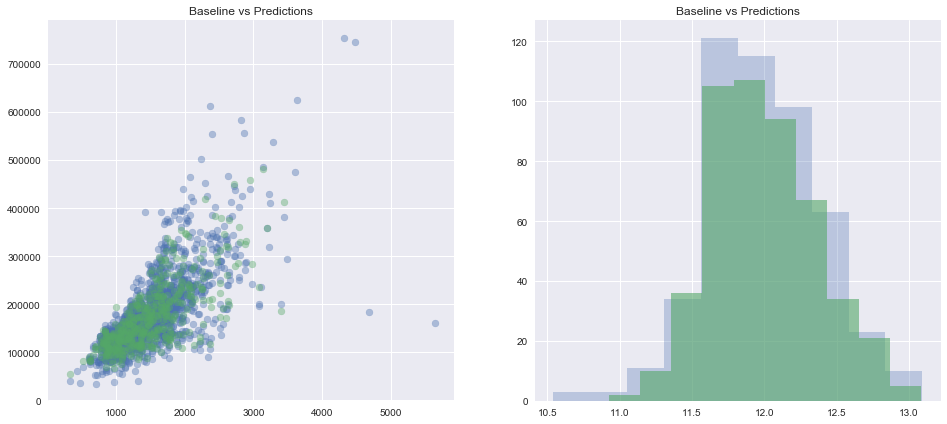

R2-score: 0.902818299725
RMSE (log): 0.12321898908624954
Fitting the pipeline to all the data...
Score: 0.92834489


In [599]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 178491.16
Difference in means is: -2430.03523266


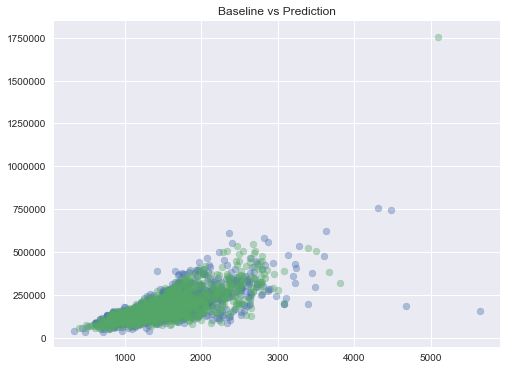

In [600]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [601]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180728095727.csv


Kaggle score: 0.12391

### Elastic net

Middle ground between lasso (l1) and ridge (l2). We try this just for fun.

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

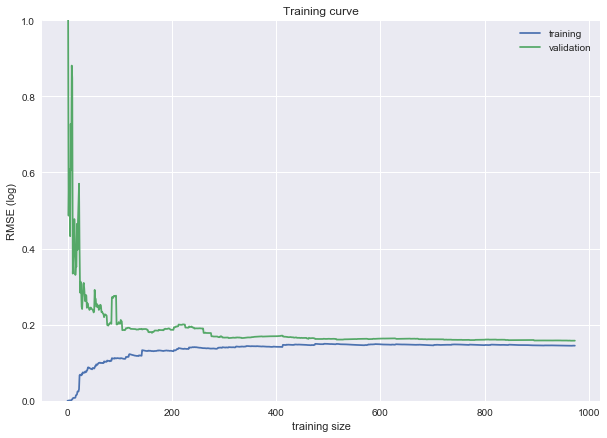

R2-score: 0.840347985351
RMSE (log): 0.15793289506830857


In [602]:
from sklearn.linear_model import ElasticNet

plot_learning_curve(trans_pipeline, 
    Pipeline([
        ('elasticnet', ElasticNet(alpha=.1, l1_ratio=.5))
]))

Result is not good. We try to do a grid search over the parameters.

In [605]:
from sklearn.model_selection import GridSearchCV       

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'elasticnet__alpha': [0.001, 0.01, 0.1, 1],
             'elasticnet__l1_ratio': [0.25, 0.5, 0.75],
             'elasticnet__normalize': [True, False]}
     
def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('elasticnet', ElasticNet())
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'elasticnet__alpha': [0.001, 0.01, 0.1, 1], 'elasticnet__l1_ratio': [0.25, 0.5, 0.75], 'elasticnet__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

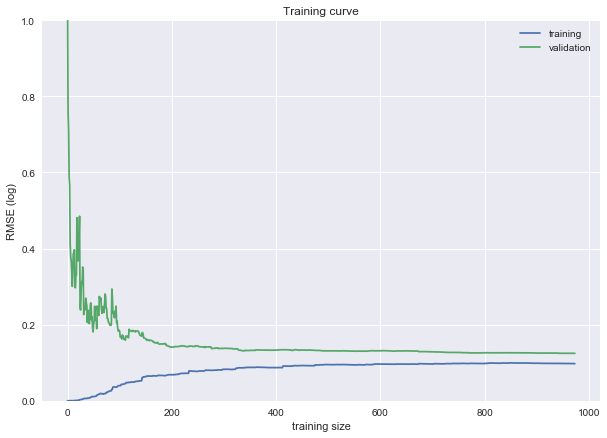

R2-score: 0.900577208273
RMSE (log): 0.12463165775138761


In [606]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Result is close to other learners. I think we need to try some another method

### DescisionTreeRegressor

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


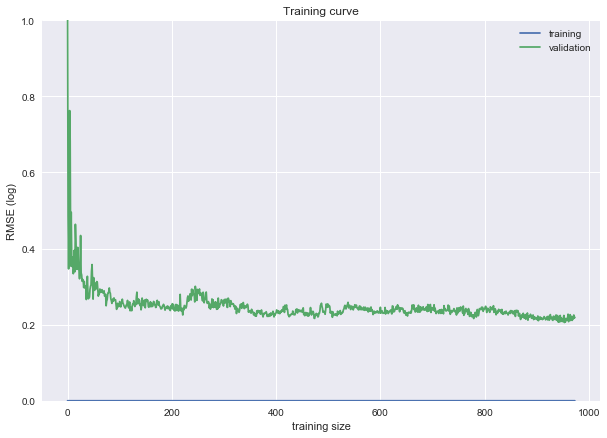

R2-score: 0.692126624989
RMSE (log): 0.21931657810170838


In [607]:
from sklearn.tree import DecisionTreeRegressor

plot_learning_curve(trans_pipeline, 
    Pipeline([
        ('tree_regressor', DecisionTreeRegressor(random_state=42))
]))

Shure, a heavy overfitting. We need to reduce the min samples per leaf.

In [609]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
        'tree_regressor__min_samples_leaf': [1, 2, 4, 10, 20, 50],
        'tree_regressor__criterion': ['mse', 'friedman_mse', 'mae'],
        'tree_regressor__splitter': ['best','random'],
}
     
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('tree_regressor', DecisionTreeRegressor(random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tree_regressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tree_regressor__min_samples_leaf': [1, 2, 4, 10, 20, 50], 'tree_regressor__criterion': ['mse', 'friedman_mse', 'mae'], 'tree_regressor__splitter': ['best', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [610]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('tree_regressor', DecisionTreeRegressor(criterion='friedman_mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best'))])

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


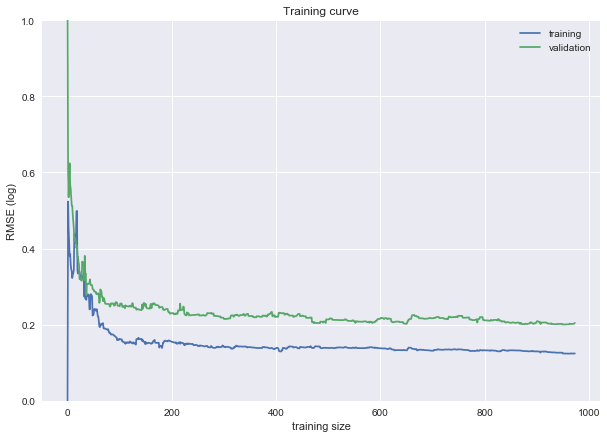

R2-score: 0.732087311113
RMSE (log): 0.20458888546065387


In [611]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.901198607792
RMSE (log): 0.12421381281994101
Create predictions...(test)


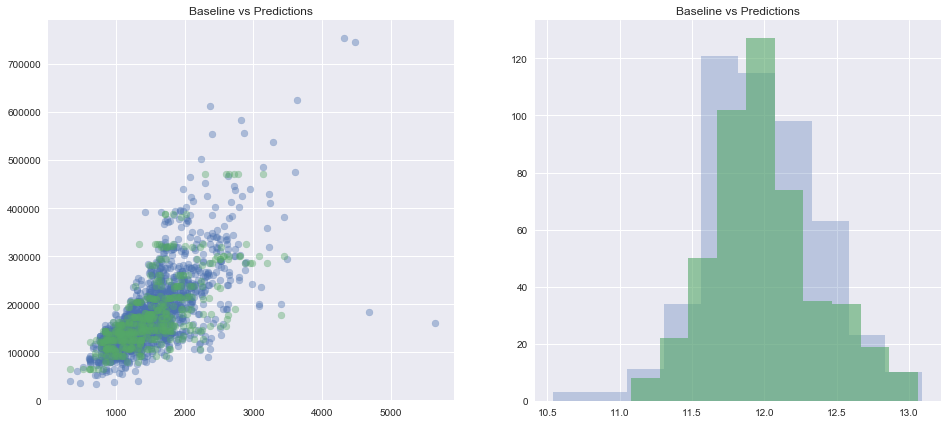

R2-score: 0.732087346958
RMSE (log): 0.20458887177437393
Fitting the pipeline to all the data...
Score: 0.90353883


In [612]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_)

A decision tree regressor is performing substantially weaker than the earlier regressors.

### Optimization 1: Introducing Bagging 

Best learner so far is ridge regression. But we did not use normalization nor did we do a good grid search. So we do this again before we apply a bagging algorithm.

In [613]:

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
    'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'ridge_regression__fit_intercept': [True, False],
    'ridge_regression__normalize': [True, False],
    'ridge_regression__fit_intercept': [True, False],
    'ridge_regression__solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
     
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('ridge_regression', Ridge(random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.034284054894927e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0095932817066929e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.733987949710132e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ridge_regression', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'ridge_regression__fit_intercept': [True, False], 'ridge_regression__normalize': [True, False], 'ridge_regression__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [614]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('ridge_regression', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='svd', tol=0.001))])

In [626]:
from sklearn.ensemble import BaggingRegressor

bag_estimator = BaggingRegressor(
        estimator.best_estimator_, n_estimators=500,
        max_samples=200, bootstrap=True, n_jobs=4
)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.92775011867
RMSE (log): 0.10622015476098734
Create predictions...(test)


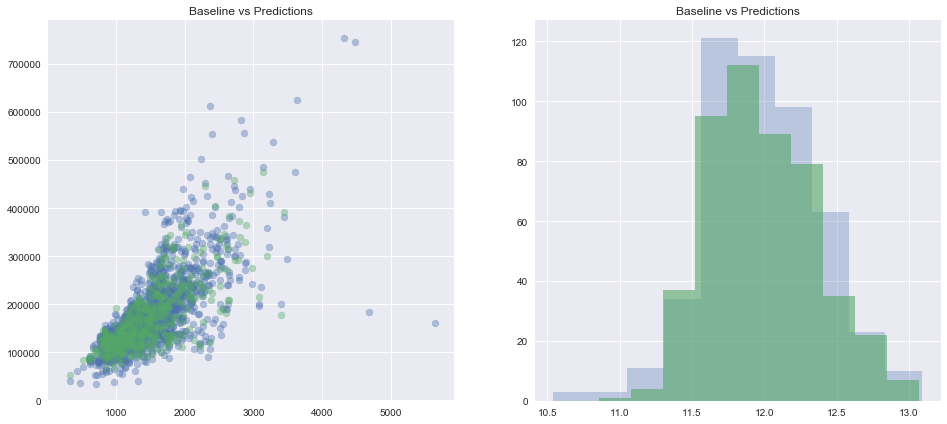

R2-score: 0.901308983171
RMSE (log): 0.12417215166133377
Fitting the pipeline to all the data...
Score: 0.91947691


In [627]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    bag_estimator)

The result is not really better, but we can try how this does score on the kaggle set.

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 178982.35
Difference in means is: -1938.84801958


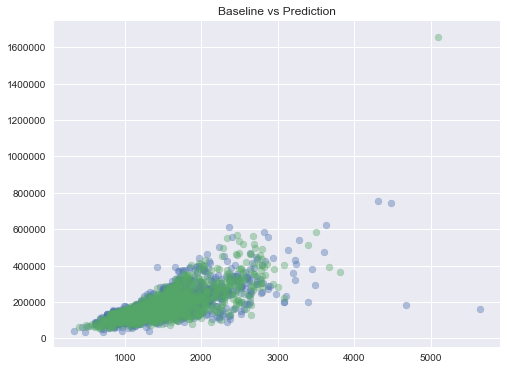

In [628]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [629]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180728113947.csv


Kaggle: 0.12484

We try to weaken the 'weak' learner and see how this is performing.

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.927723619149
RMSE (log): 0.10623963247585456
Create predictions...(test)


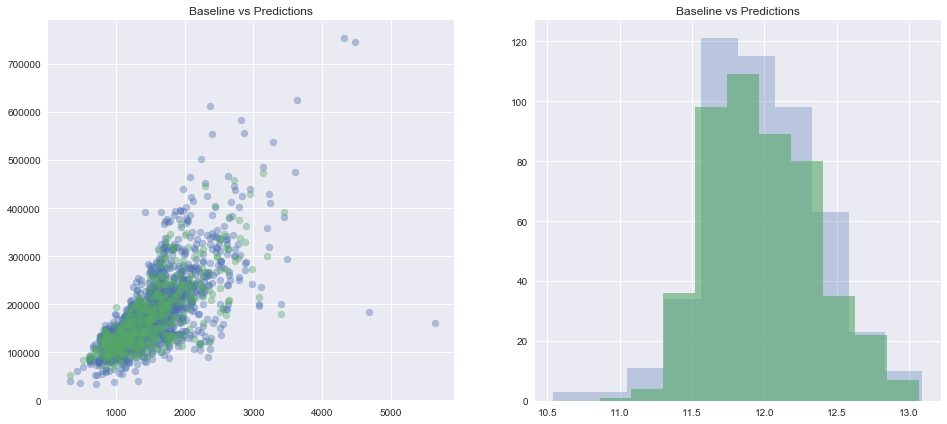

R2-score: 0.901727267342
RMSE (log): 0.12390873155526672
Fitting the pipeline to all the data...
Score: 0.92002241


In [634]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
        BaggingRegressor(
        Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,random_state=42), 
            n_estimators=500, max_samples=200, bootstrap=True, n_jobs=4))

Bagging was no help at all. The learners are probably not week enough to achieve better results when combining.

We try a RandomForestRegressor which basically does the bagging within

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


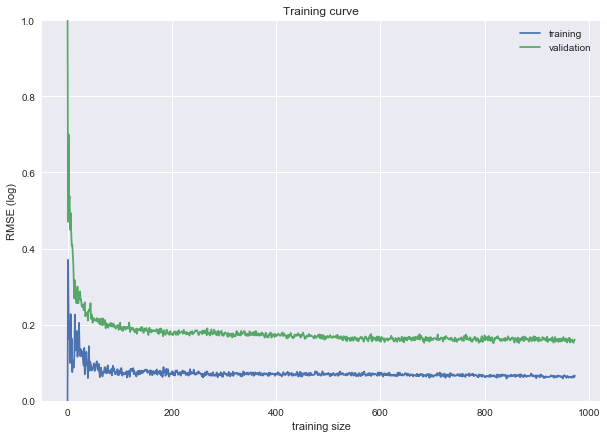

R2-score: 0.834692165029
RMSE (log): 0.16070600824929887


In [636]:
from sklearn.ensemble import RandomForestRegressor

plot_learning_curve(trans_pipeline, 
    Pipeline([
        ('random_forest', RandomForestRegressor(n_estimators=10))
]))

Naturally we have a very heavy overfitting when only 10 estimators are taken and the min_numbers_split is not set which defaults to 1.

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

In [33]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
    'random_forest__criterion': ['mse','mae'],
    'random_forest__oob_score': [True, False],
}
    
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('random_forest', RandomForestRegressor(n_estimators=50))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('random_forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'random_forest__criterion': ['mse', 'mae'], 'random_forest__oob_score': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [34]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('random_forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False))])

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.983537657797
RMSE (log): 0.050703060344946774
Create predictions...(test)


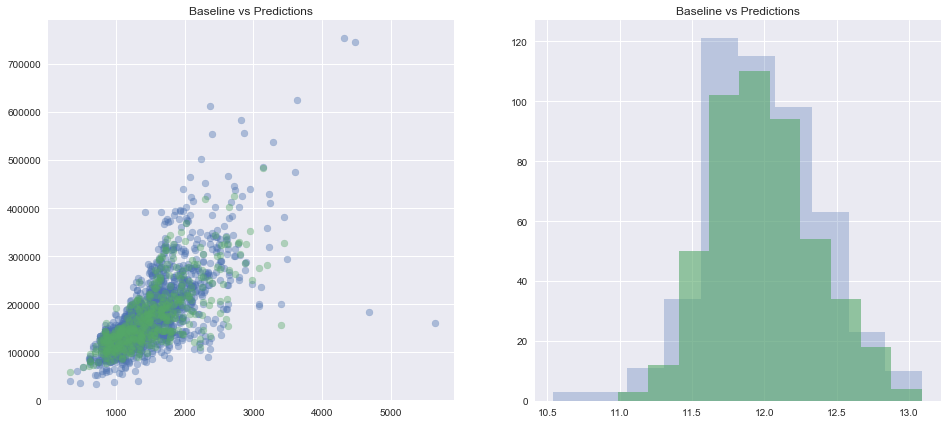

R2-score: 0.856583400175
RMSE (log): 0.14968735203496278
Fitting the pipeline to all the data...
Score: 0.98381411


In [36]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False))

Random forest does also not yield better results. It bascially is a bagging mechanism and we did expect something like this.

### Optimization 2: Boosting

Bagging was not very successful so we try boosting as another ensemble method. We try two different boosting method here: AdaBoost and XGBoost (kaggle winner here and there)

In [41]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
    'ada_boost__loss': ['linear', 'square', 'exponential']
}
     
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('ada_boost', AdaBoostRegressor(
                                    base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
                                       normalize=False, random_state=42, solver='cholesky', tol=0.001),
                                    n_estimators=100))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ada_boost', AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ada_boost__loss': ['linear', 'square', 'exponential']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [42]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('ada_boost', AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None))])

The best loss function seams to be linear. How to interpret? Don't know. Let see what this brings. It did not bring any good so we are experimenting with learning_rate.

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.942494151866
RMSE (log): 0.09476421455353426
Create predictions...(test)


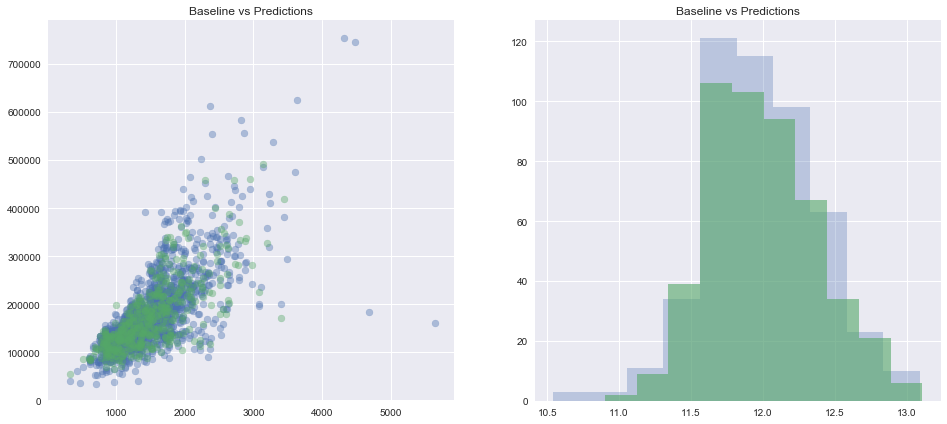

R2-score: 0.901579318728
RMSE (log): 0.12400196815347336
Fitting the pipeline to all the data...
Score: 0.93509998


In [56]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=.001, loss='linear', n_estimators=100,
         random_state=42))

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179180.63
Difference in means is: -1740.56648916


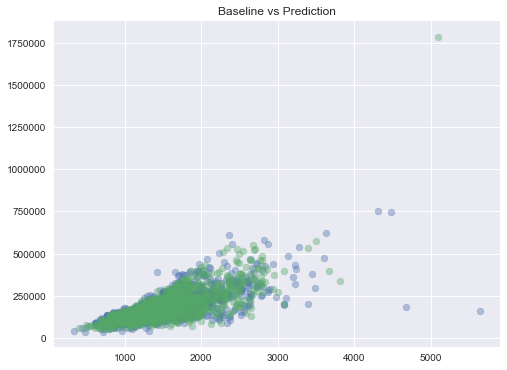

In [57]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [58]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180728143142.csv


Kaggle score: 0.12088

We try gradient boosting as well before tryig xgboost:

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.943812534362
RMSE (log): 0.09367163107514748
Create predictions...(test)


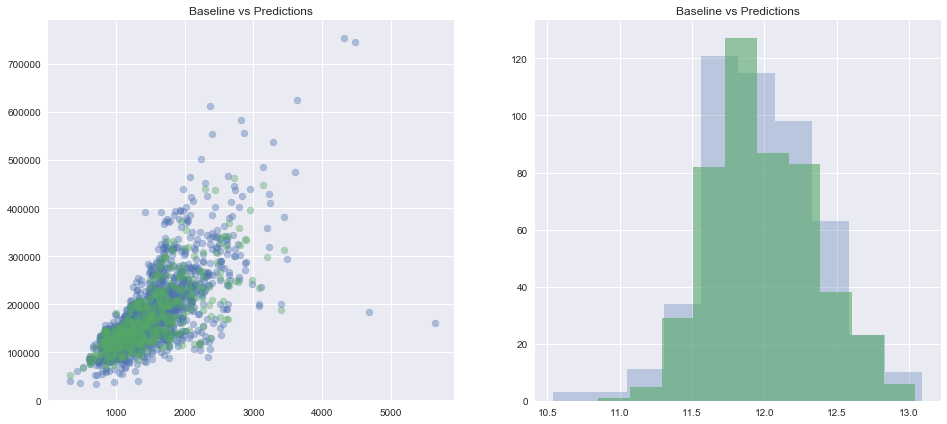

R2-score: 0.891282534094
RMSE (log): 0.13032719714679042
Fitting the pipeline to all the data...
Score: 0.92672761


In [72]:
from sklearn.ensemble import GradientBoostingRegressor

(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    GradientBoostingRegressor(max_depth=2, n_estimators=1000, learning_rate=.01, warm_start=True))

No parameters did bring better results. I think we should try an algorithm which is not from sklearn to compare results.

#### Non sklearn learning

In [78]:
import xgboost as xgb

In [85]:
xgb.XGBRegressor().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [88]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
                'xgboost__booster': ['gbtree', 'gblinear','dart'],
                'xgboost__learning_rate': [.1, .3, .9],
                'xgboost__gamma': [0, 1, 10, 20],
                'xgboost__max_depth': [1, 3, 6],
                'xgboost__subsample': [.2, .4, .6],
             }

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('xgboost', xgb.XGBRegressor(n_estimators=50, random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('xgboost', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgboost__booster': ['gbtree', 'gblinear', 'dart'], 'xgboost__learning_rate': [0.1, 0.3, 0.9], 'xgboost__gamma': [0, 1, 10, 20], 'xgboost__max_depth': [1, 3, 6], 'xgboost__subsample': [0.2, 0.4, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.965045764124
RMSE (log): 0.07339962648146511
Create predictions...(test)


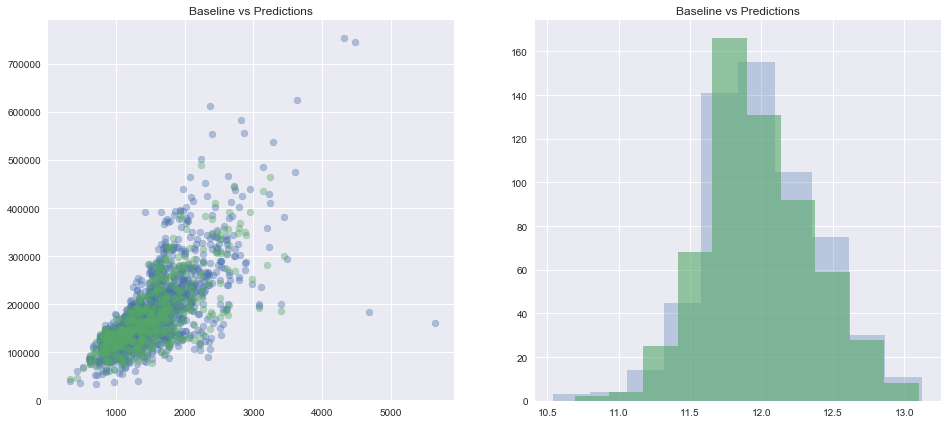

R2-score: 0.888841486359
RMSE (log): 0.1332962190219232
Fitting the pipeline to all the data...
Score: 0.95117544


In [92]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_, size_test=.4)

Does not behave any better than the sklearn ensembles. We try another algorithm class altogether.

### Optimization 3: Neural Net

In [12]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed


In [35]:
import helper_functions

In [45]:
import importlib
importlib.reload(helper_functions)
from helper_functions import *

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from helper_functions import *

%matplotlib inline
seaborn.set()

import helper_functions

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

class NoFitMixin:
    def fit(self, X, y=None):
        return self

# class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy

    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        return self.func(X_)
        from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer

def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ])

Define network

In [203]:
import numpy as np
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
def build_nn():
    model = Sequential()
    model.add(Dense(219, kernel_initializer='normal', activation='relu', input_shape=(219,)))
    model.add(Dropout(.2))
    model.add(Dense(110, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))

    # Compiling the model
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [204]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


In [205]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=42)

In [206]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint  
import livelossplot as lp

plot_callback = lp.PlotLossesKeras()
callbacks = [plot_callback] #, checkpointer]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regressor', KerasRegressor(build_fn=build_nn, batch_size=5, epochs=500, callbacks=callbacks, 
                                     validation_data=(X_test, y_test)))
])

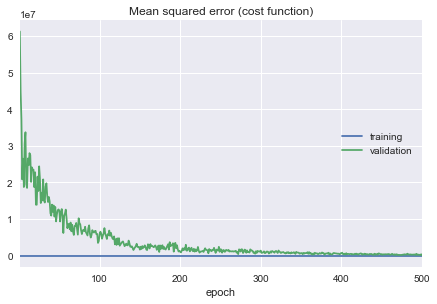

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp_regressor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x0000025E440E8400>)])

In [207]:
pipeline.fit(X_train, y_train)

In [208]:
predictions = pipeline.predict(X_test)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 162965.34
Difference in means is: -17955.8521404


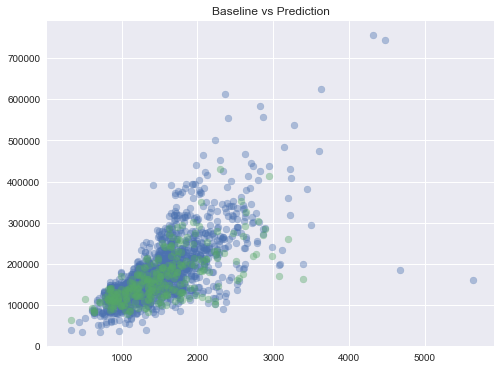

In [210]:
pred = np.expm1(predictions)
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
fig, ax = plt.subplots(1, figsize=(8, 6), sharey=True)
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.4)
ax.set_title('Baseline vs Prediction')
#ax.set_ylim(0, 1000000)
ax.scatter(X_test['GrLivArea'], pred, alpha=.4)
print('Mean of Salesprice in Training-Data: %.2f' % train_df['SalePrice'].mean())
print('Mean of Salesprice in predictions: %.2f' % pred.mean())
difference = pred.mean() - train_df['SalePrice'].mean()
print('Difference in means is: %s' % difference)

In [211]:
print_benchmark(y_test, predictions, False)

R2-score: 0.836023803499
RMSE (log): 0.16092902206605617


The crossvalidation is probably not right (the graph above). But this does not trouble us !!. We just try another model.

In [333]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


In [334]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.25, random_state=42)

In [335]:
def build_nn2():
    model = Sequential()
    model.add(Dense(219, kernel_initializer='normal', activation='relu', input_shape=(219,)))
    model.add(Dropout(.2))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))

    # Compiling the model
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [336]:
X_transformed = StandardScaler().fit_transform(X_test)

In [337]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regressor', KerasRegressor(build_fn=build_nn2, batch_size=5, epochs=500, verbose=1, callbacks=callbacks, 
                                     validation_data=(X_transformed, y_test)))
])

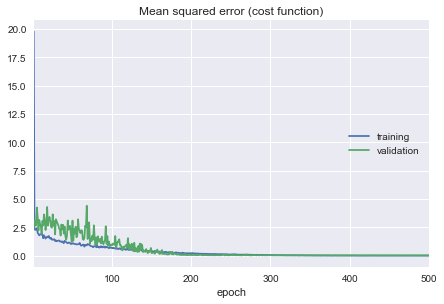

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp_regressor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x0000025E67EE0710>)])

In [338]:
pipeline.fit(X_train, y_train)

In [339]:
predictions = pipeline.predict(X_test)
print_benchmark(y_test, predictions, False)

364/364 [==============================] - 2s 4ms/step
R2-score: 0.841251022815
RMSE (log): 0.15610111110738842


The model is not very good but was still improving in the end.